In [9]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import numpy as np
import scipy.integrate as integ
from astropy.io import ascii
from scipy import interpolate
import scipy.stats as stats
from astropy.table import Table, Column
import readsnap as rs
reload(rs)


plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 15


# Constants in CGS

G = 6.6726e-08
Ro = 6.96e10
Mo = 1.99e33
c = 2.9979e+10
day = 60*60*24

DistUnit = Ro
MassUnit = Mo
TimeUnit = np.sqrt(DistUnit**3/(G*MassUnit))
VelUnit = DistUnit/TimeUnit
AngMomUnit = DistUnit*VelUnit*MassUnit

SpinUnit = AngMomUnit*c/(G*Mo**2)



Tday = TimeUnit/(60*60*24)

#=====================================================
# Finds index of the element in an array 
# with the closest value to "value"

def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
#     return array[idx]
        return idx






In [10]:
def snapdata(path,snap):
    data = rs.readsnap(path,snap,0)
    dataBH = rs.readsnap(path,snap,5,skip_bh = 1)
    dataSTAR = rs.readsnap(path,snap,4)
    
    return data,dataBH,dataSTAR

def Get_dynamics(filename):

    """Getting the data from the dynmaics file"""
    
    dyn = np.genfromtxt(filename)    
    
    colnames = ('t','Macc_bh','Engy_bh','PaccX_bh','PaccY_bh','PaccZ_bh','LaccX_bh','LaccY_bh' \
                ,'LaccZ_bh','M_gas','X_gas','Y_gas','Z_gas','PX_gas','PY_gas','PZ_gas' \
                ,'LX_gas','LY_gas','LZ_gas', 'M_star','X_star','Y_star','Z_star','PX_star' \
                ,'PY_star','PZ_star','LX_star','LY_star','LZ_star','M_bh','X_bh','Y_bh' \
                ,'Z_bh','PX_bh','PY_bh','PZ_bh','LX_bh','LY_bh','LZ_bh','Macc_star', 'Engy_star' \
                ,'PaccX_star','PaccY_star','PaccZ_star','LaccX_star','LaccY_star' \
                ,'LaccZ_star','LaccX_starCM','LaccY_starCM','LaccZ_starCM','LaccX_bhCM' \
                ,'LaccY_bhCM','LaccZ_bhCM','rp')
    
    print np.shape(dyn), len(colnames)
    dat = Table(dyn,names=colnames)
    

    return dat



In [11]:
def vrad(data,dataBH):
    
    # get position and velocity from bh frame
    posgasX = data['p'][:,0] - dataBH['p'][0,0] 
    posgasY = data['p'][:,1] - dataBH['p'][0,1] 
    posgasZ = data['p'][:,2] - dataBH['p'][0,2] 

    velgasX = data['v'][:,0] - dataBH['v'][0,0] 
    velgasY = data['v'][:,1] - dataBH['v'][0,1] 
    velgasZ = data['v'][:,2] - dataBH['v'][0,2] 

    # radius and radial velocity
    R = np.sqrt(posgasX**2 + posgasY**2 + posgasZ**2)
    Vrad  = (velgasX*posgasX + velgasY*posgasY + velgasZ*posgasZ)/R
    
    # Angular momentum of each particle
    A = (posgasX*velgasY - posgasY*velgasX)*data['m']
    
    # bin for plotting
    nbin = 400
    Vradb, Rb, bin_id = stats.binned_statistic(R,Vrad,bins=nbin,statistic='mean')
    Rave = (Rb[:-1] + Rb[1:])*0.5
    
    Mbin, Rb, bin_id = stats.binned_statistic(R,data['m'],statistic='sum',bins=nbin)
    Rave = (Rb[:-1] + Rb[1:])*0.5
    
    Abin, Rb, bin_id = stats.binned_statistic(R,A,statistic='sum',bins=nbin)
    
    #getting bh data
    Mbh0 = dataBH['m']

    return R,Vrad,A,Rave,Vradb,(np.cumsum(Mbin)+Mbh0),Abin


def escvel(data,dataBH):
    
    R,Vrad,A,Rave,Vradb,Mbin,Abin = vrad(data,dataBH)
    
    vesc = np.sqrt(2*G*Mbin*Mo/(Rave*Ro))

    return R,Vrad,A,Rave,Vradb,Mbin,vesc,Abin
    
    

## Estimating the amount of torqued material



The bound material will reach a radius $r_{max}$:

\begin{equation}
\frac{1}{2} m v_i^2 - \frac{GM(r)m}{r_i} = - \frac{GM(r)m}{r_{max}}
\end{equation}

\begin{equation}
\rightarrow r_{max} = \frac{- GM(r)m}{\frac{1}{2} m v_i^2 - \frac{GM(r)m}{r_i}} = \frac{- GM(r)}{\frac{1}{2} v_i^2 - \frac{GM(r)}{r_i}}
\end{equation}

Deviding by $v_{esc}^2=\frac{2GM(r)}{r_i}$:
\begin{equation}
r_{max} = \frac{- \frac{1}{2}r_i} {\frac{1}{2}\left(\frac{v_i}{v_{esc}}\right)^2 - \frac{1}{2} } = \frac{r_i} {1 -\left(\frac{v_i}{v_{esc}}\right)^2 }
\end{equation}

gives an nice version of $r_{max}$.

Because the velocity profiles are very steep, the fast ejecta will leave the binary quickly, and material below escape velocity will fall back pretty quickly. The small amount of material that will be torqued significantly, is the material reaching the orbital separation, before collapsing back onto the black hole.

The amount of material directly accreted depends on how strong the explosion is 


In [12]:
# function for looping through all R values needed
def masscal(path,snap,Rlist):                         # path is the directory of the snapshots
                                                      # snap is one number from a list with the number of snapshots
                                                      # Rlist is a list of interesting R values for mass position
                                                      
    #get data from snapshot
    data,dataBH,dataSTAR = snapdata(path,snap)
    
    #get BINNED radius, velocity, masscoordinate and escape velocity 
    R,Vrad,A,Rave,Vradbin,M,vesc,Abin = escvel(data,dataBH)
    
    # bound material has velocity below escape velocity
    mfunc    = interpolate.interp1d(Rave, M,bounds_error=None,fill_value='extrapolate')
    vesc     = np.sqrt(2*G*mfunc(R)*Mo/(R*Ro))
    
    bound    = Vrad*VelUnit<vesc
    
    # create arrays for bound material (not binned quantities)
    Rb    = np.array(R[bound])
    Vradb = np.array(Vrad[bound])
    vescb = np.array(vesc[bound])
    Ab    = np.array(A[bound])
    
    
    # maximum radius reached
    rmax = Rb / (1.0 - (Vradb*VelUnit/vescb)**2)
    
    # lost mass with velocity above escape
    Mlost = sum(data['m'][~bound])
    
    # bound particles with velocity below escape
    Mbound = data['m'][bound]
    
    # find amount of already acrreted angular momentum from dyn file
    dyn = Get_dynamics(path+'/dynamics.txt')
    idx = find_nearest(dyn['M_bh'],dataBH['m'])
    Lacc = dyn['LaccZ_bh'][idx]
    print 'is ths the right type ',type(Lacc),type(dataBH['m'][0])
    
    # mass passing list of important radii
    Mdisk   = np.zeros(len(Rlist))
    Mdirect = np.zeros(len(Rlist))

    # Ang mom passing list of important radii
    Angdisk   = np.zeros(len(Rlist))
    Angdirect = np.zeros(len(Rlist))
    

    for i in range(len(Rlist)):
        
        Mdirect[i] = sum(Mbound[rmax<Rlist[i]])+dataBH['m'][0]
        Mdisk[i]   = sum(Mbound[rmax>Rlist[i]])  
        
        Angdirect[i] = sum(Ab[rmax>Rlist[i]])+Lacc
        Angdisk[i]   = sum(Ab[rmax<Rlist[i]])
    
    return Mbound,Mlost,Mdisk,Mdirect,Angdisk,Angdirect






## Estimating the spin

for $z_1$ and $M_1$ are the initial values
\begin{equation}
\frac{z}{z_1} = \left(\frac{M_1}{M}\right)^2
\end{equation}

From this equation get the new $z$ given the amount of final mass, value and calculate a 
\begin{equation}
a(z) = \frac{1}{3} z^{1/2} \left[ 4- (3z - 2)^{1/2} \right]
\end{equation}


In [13]:
# spin already accreted
def spin(dyn):
    Lacc = (np.sqrt(dyn['LaccZ_bh']**2))*AngMomUnit
    bh_spin = Lacc*c/(G*(dyn['M_bh']*Mo)**2)
    return bh_spin

def geta_direct(Angdirect,Mdirect):
    
    # get spin from total angular momentum accreted directly
    Lacc = np.sqrt(Angdirect**2)*AngMomUnit 
    spindirect = Lacc*c/(G*((Mdirect)*Mo)**2)
    
    return spindirect

def get_r_isco(a):
    
    
    print 'what type is a ',type(a),'and its shape',np.shape(a)
    w1 = 1. + (1. - a**2.)**(1./3.) * ((1. + a)**(1./3.) + (1 - a)**(1./3.))
    w2 = (3.*a**2 + w1**2.)**(1./2.)
    
    # z = r_isco/M
    z = 3 + w2 - ((3 - w1)*(3 + w1 + 2*w2))**(1./2.)
    return z


def disk(Mdirect,Mlist,Angdirect):
    
    # get spin from directly falling material
    a_direct = geta_direct(Angdirect,Mdirect)
    
    
    # get new r_ISCO
    z_1 = get_r_isco(a_direct)
    Mfinal = Mdirect + Mlist
    z = (Mdirect/Mfinal)**2 * z_1
    
    
    afinal = 1./3. * z**(1./2.) * (4 - np.sqrt(3.*z - 2) )
    
    return afinal



# Here is the file going in...

In [22]:
#set directory path
Apath10 = '/Users/alejandro/Dropbox/Alejandro_CE_SN/Data/0608_4/'

#get dynamics file
# filename = Apath10 + 'dynamics.txt'
# Adyn10 = Get_dynamics(filename)

# choose snapshot for calculation
snap = 11

#get data from snapshot for gas particles and star sink particle and Bh sink particle
Adata10,AdataBH10,AdataSTAR10 = snapdata(Apath10,snap)



#calculate radial velocity
R,Vrad,A,ARave10,AVradbin10,AMbin10,Avesc10,AAbin10 = escvel(Adata10,AdataBH10)



### this is for estimation of spin

# list of separations, we want to estimate spin for 
# Rlist = np.logspace(-1,1,10) # in code units
Rlist = np.linspace(0.1,2,10) # in code units
Mbound,Mlost,Mdisk,Mdirect,Angdisk,Angdirect = masscal(Apath10,snap,Rlist)


# Aspinlist10 = disk(AMdirect10,AMlist10,AAngdirect10)




This is the filename /Users/alejandro/Dropbox/Alejandro_CE_SN/Data/0608_4//snapshot_011.hdf5
('npart_file: ', array([845636,      0,      0,      0,      1,      1], dtype=int32))
('npart_total:', array([845636,      0,      0,      0,      1,      1], dtype=uint32))
This is the filename /Users/alejandro/Dropbox/Alejandro_CE_SN/Data/0608_4//snapshot_011.hdf5
('npart_file: ', array([845636,      0,      0,      0,      1,      1], dtype=int32))
('npart_total:', array([845636,      0,      0,      0,      1,      1], dtype=uint32))
This is the filename /Users/alejandro/Dropbox/Alejandro_CE_SN/Data/0608_4//snapshot_011.hdf5
('npart_file: ', array([845636,      0,      0,      0,      1,      1], dtype=int32))
('npart_total:', array([845636,      0,      0,      0,      1,      1], dtype=uint32))
This is the filename /Users/alejandro/Dropbox/Alejandro_CE_SN/Data/0608_4//snapshot_011.hdf5
('npart_file: ', array([845636,      0,      0,      0,      1,      1], dtype=int32))
('npart_total:',

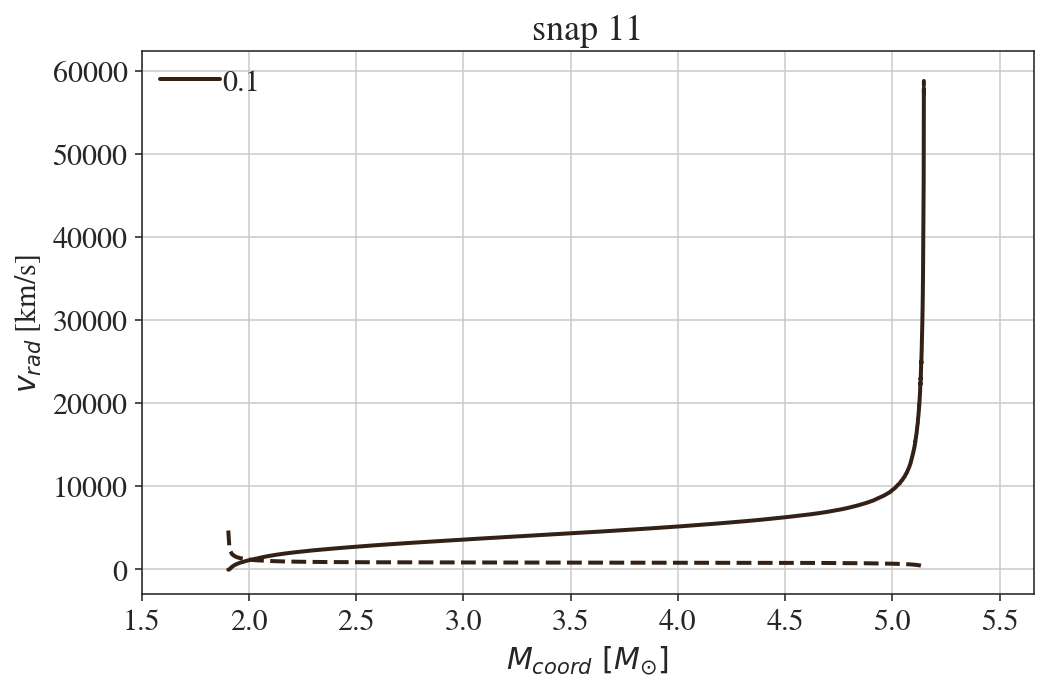

In [24]:
def plotting_v(Mbin,Vradbin,vesc,snap):
    plt.plot(Mbin,Vradbin*VelUnit/1e5,color=plt.cm.copper(1./6.),label='0.1')
    plt.plot(Mbin,vesc/1e5,'--',color=plt.cm.copper(1./6.))
    
    plt.xlabel(r'$M_{coord}\ [M_{\odot}]$')
    plt.ylabel(r'$v_{rad}$ [km/s]')
#     plt.ylim(-5000,5000)
    plt.xlim(1.5,1.1*Mbin[-1])
    plt.legend(loc='best')
    plt.grid()
    plt.title('snap '+ str(snap))
    
plotting_v(AMbin10,AVradbin10,Avesc10,snap)
plt.savefig(Apath10+str(snap)+'.png')

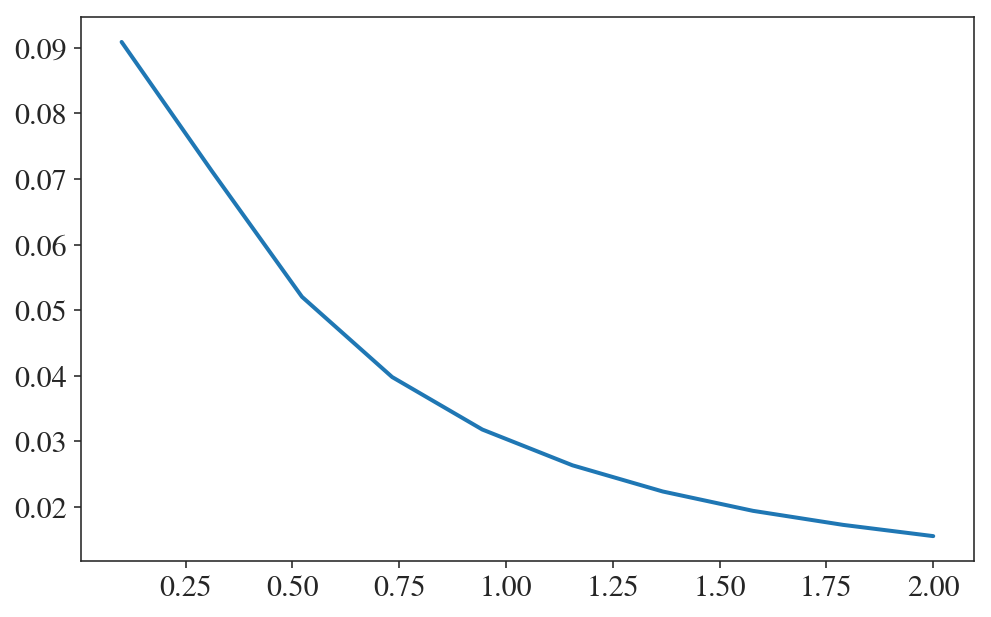

In [23]:
plt.plot(Rlist,Mdisk)
plt.plot(Rlist,Mdirect)